## Sentiment Analysis Model

#### Imports

In [29]:
import pandas as pd
import numpy as np
from numpy import asarray
from numpy import zeros
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

#### Text preprocessing and Embedding:

In [5]:
df_train = pd.read_csv('../Dataset/Train.csv')
df_test = pd.read_csv('../Dataset/Test.csv')
df_valid = pd.read_csv('../Dataset/Valid.csv')

In [6]:
df_train.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [7]:
# shapes of the dataframes
print(df_train.shape)
print(df_test.shape)
print(df_valid.shape)

(40000, 2)
(5000, 2)
(5000, 2)


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


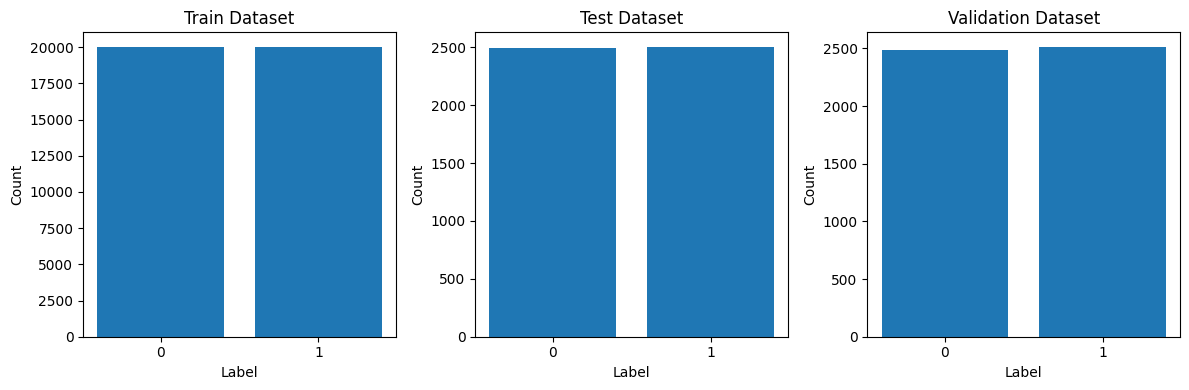

In [17]:
# Count the occurrences of each label in train, test, and val datasets
train_label_counts = df_train['label'].value_counts()
test_label_counts = df_test['label'].value_counts()
val_label_counts = df_valid['label'].value_counts()

# Set up the figure and axes for subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# Plot train dataset
axes[0].bar(train_label_counts.index, train_label_counts.values)
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].set_title('Train Dataset')
axes[0].set_xticks(train_label_counts.index)

# Plot test dataset
axes[1].bar(test_label_counts.index, test_label_counts.values)
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')
axes[1].set_title('Test Dataset')
axes[1].set_xticks(test_label_counts.index)

# Plot validation dataset
axes[2].bar(val_label_counts.index, val_label_counts.values)
axes[2].set_xlabel('Label')
axes[2].set_ylabel('Count')
axes[2].set_title('Validation Dataset')
axes[2].set_xticks(val_label_counts.index)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


In [19]:
df_train["text"][2]

'Why do people who do not know what a particular time in the past was like feel the need to try to define that time for others? Replace Woodstock with the Civil War and the Apollo moon-landing with the Titanic sinking and you\'ve got as realistic a flick as this formulaic soap opera populated entirely by low-life trash. Is this what kids who were too young to be allowed to go to Woodstock and who failed grade school composition do? "I\'ll show those old meanies, I\'ll put out my own movie and prove that you don\'t have to know nuttin about your topic to still make money!" Yeah, we already know that. The one thing watching this film did for me was to give me a little insight into underclass thinking. The next time I see a slut in a bar who looks like Diane Lane, I\'m running the other way. It\'s child abuse to let parents that worthless raise kids. It\'s audience abuse to simply stick Woodstock and the moonlanding into a flick as if that ipso facto means the film portrays 1969.'

Some text cleaning like removing characters and stopwords.

In [20]:
# text preprocessing
import re
import string

def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)

    return text

In [21]:
# Apply the cleaning function to both test and training datasets
df_train['text'] = df_train['text'].apply(lambda x: clean_text(x))
df_test['text'] = df_test['text'].apply(lambda x: clean_text(x))
df_valid['text'] = df_valid['text'].apply(lambda x: clean_text(x))

In [22]:
# remove stopwords
from nltk.corpus import stopwords

stop = stopwords.words('english')

df_train['text'] = df_train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_test['text'] = df_test['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_valid['text'] = df_valid['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Error loading stopwords: <urlopen error [Errno 60]
[nltk_data]     Operation timed out>


In [23]:
df_train['text'][2]

'people know particular time past like feel need try define time others replace woodstock civil war apollo moonlanding titanic sinking youve got realistic flick formulaic soap opera populated entirely lowlife trash kids young allowed go woodstock failed grade school composition ill show old meanies ill put movie prove dont know nuttin topic still make money yeah already know one thing watching film give little insight underclass thinking next time see slut bar looks like diane lane im running way child abuse let parents worthless raise kids audience abuse simply stick woodstock moonlanding flick ipso facto means film portrays'

<b>Creating an Embedding layer:</b><br>
Embedding layer converts our textual data into numeric form. It is then used as the first layer for the deep learning models in Keras.

In [24]:
# split the data into x_train and y_train dataframes
x_train = df_train['text']
y_train = df_train['label']

# split the data into x_test and y_test dataframes
x_test = df_test['text']
y_test = df_test['label']

# split the data into x_valid and y_valid dataframes
x_valid = df_valid['text']
y_valid = df_valid['label']

In [26]:
# Embedding layer expects the words to be in numeric form 
# Using Tokenizer function from keras.preprocessing.text library to convert text to sequences

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(x_train)

X_train = word_tokenizer.texts_to_sequences(x_train)
X_test = word_tokenizer.texts_to_sequences(x_test)

In [27]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

155599

In [28]:
# Padding all reviews to fixed length 100
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [31]:
# loading GloVe word embeddings

embeddings_dictionary = dict()
glove_file = open('../Dataset/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [32]:
# Create Embedding Matrix having 100 columns 
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [33]:
embedding_matrix.shape

(155599, 100)

#### Simple Neural Network

In [34]:
# Neural Network architecture
snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)
snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [35]:
# Model compiling
snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
snn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          15559900  
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 15569901 (59.39 MB)
Trainable params: 10001 (39.07 KB)
Non-trainable params: 15559900 (59.36 MB)
_________________________________________________________________


In [37]:
# Model training
snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_split=0.2)

Epoch 1/50
250/250 [==============================] - 0s 1ms/step - loss: 0.3251 - acc: 0.8598 - val_loss: 0.6102 - val_acc: 0.7402
Epoch 2/50
250/250 [==============================] - 0s 1ms/step - loss: 0.3206 - acc: 0.8617 - val_loss: 0.6223 - val_acc: 0.7385
Epoch 3/50
250/250 [==============================] - 0s 1ms/step - loss: 0.3197 - acc: 0.8625 - val_loss: 0.6587 - val_acc: 0.7264
Epoch 4/50
250/250 [==============================] - 0s 1ms/step - loss: 0.3141 - acc: 0.8638 - val_loss: 0.6506 - val_acc: 0.7334
Epoch 5/50
250/250 [==============================] - 0s 1ms/step - loss: 0.3130 - acc: 0.8650 - val_loss: 0.6738 - val_acc: 0.7315
Epoch 6/50
250/250 [==============================] - 0s 1ms/step - loss: 0.3090 - acc: 0.8666 - val_loss: 0.6740 - val_acc: 0.7366
Epoch 7/50
250/250 [==============================] - 0s 983us/step - loss: 0.3053 - acc: 0.8679 - val_loss: 0.6784 - val_acc: 0.7351
Epoch 8/50
250/250 [==============================] - 0s 1ms/step - loss: 

In [39]:
# Predictions on the Test Set
score = snn_model.evaluate(X_test, y_test, verbose=1)

157/157 [==============================] - 0s 484us/step - loss: 0.9777 - acc: 0.7190


In [40]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.9776890873908997
Test Accuracy: 0.718999981880188


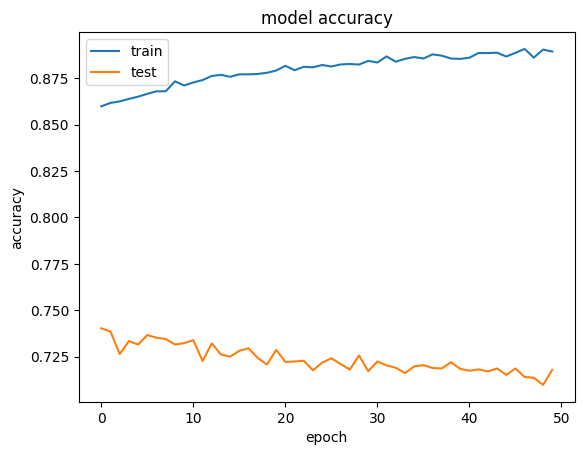

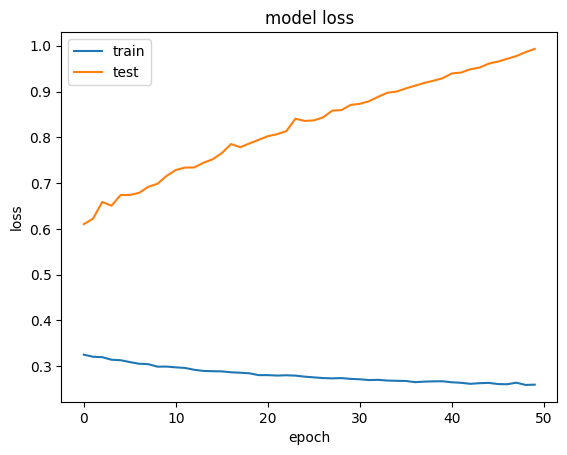

In [41]:
# Performance Visualization

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

#### Convolutional Neural Network

In [42]:
from keras.layers import Conv1D

In [43]:
# CNN architecture

cnn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)
cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [44]:
# Model compiling
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          15559900  
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 15624157 (59.60 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 15559900 (59.36 MB)
_________________________________________________________________


In [46]:
# Model training
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_split=0.2)

Epoch 1/50
250/250 [==============================] - 4s 18ms/step - loss: 0.2900 - acc: 0.8807 - val_loss: 0.3466 - val_acc: 0.8450
Epoch 2/50
250/250 [==============================] - 4s 17ms/step - loss: 0.2437 - acc: 0.9070 - val_loss: 0.3485 - val_acc: 0.8500
Epoch 3/50
250/250 [==============================] - 4s 16ms/step - loss: 0.2043 - acc: 0.9302 - val_loss: 0.3337 - val_acc: 0.8561
Epoch 4/50
250/250 [==============================] - 4s 17ms/step - loss: 0.1707 - acc: 0.9467 - val_loss: 0.3348 - val_acc: 0.8561
Epoch 5/50
250/250 [==============================] - 4s 17ms/step - loss: 0.1347 - acc: 0.9678 - val_loss: 0.3454 - val_acc: 0.8554
Epoch 6/50
250/250 [==============================] - 4s 17ms/step - loss: 0.1131 - acc: 0.9750 - val_loss: 0.3487 - val_acc: 0.8551
Epoch 7/50
250/250 [==============================] - 4s 18ms/step - loss: 0.0885 - acc: 0.9862 - val_loss: 0.3587 - val_acc: 0.8509
Epoch 8/50
250/250 [==============================] - 4s 17ms/step - 

In [47]:
# Predictions on the Test Set
score = cnn_model.evaluate(X_test, y_test, verbose=1)

157/157 [==============================] - 0s 2ms/step - loss: 0.9878 - acc: 0.8378


In [48]:
# Model Performance
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.9877853393554688
Test Accuracy: 0.8378000259399414


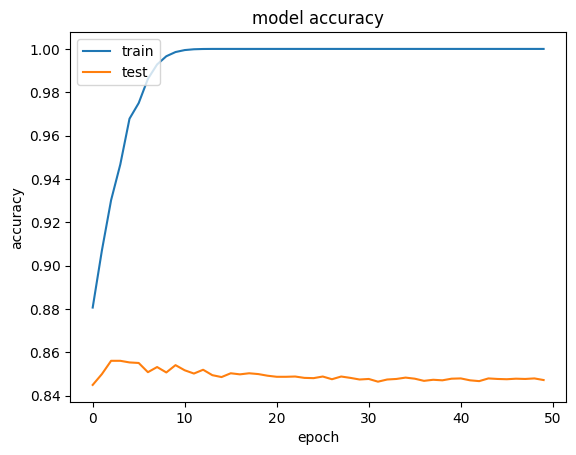

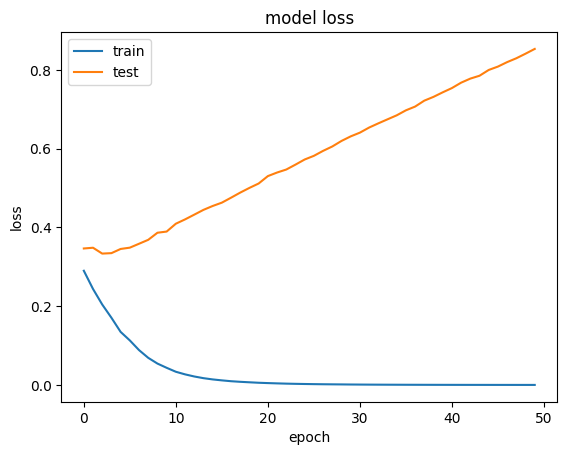

In [49]:
# Performance Visualization

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

#### Long Short Term Memory (LSTM) Neural Network

In [50]:
from keras.layers import LSTM

In [51]:
# LSTM Architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))
lstm_model.add(Dense(1, activation='sigmoid'))

In [52]:
# Model compiling
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          15559900  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 15677277 (59.80 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 15559900 (59.36 MB)
_________________________________________________________________


In [53]:
# Model Training
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
250/250 [==============================] - 24s 95ms/step - loss: 0.5076 - acc: 0.7543 - val_loss: 0.4298 - val_acc: 0.8125
Epoch 2/20
250/250 [==============================] - 24s 94ms/step - loss: 0.4223 - acc: 0.8138 - val_loss: 0.4621 - val_acc: 0.7843
Epoch 3/20
250/250 [==============================] - 23s 94ms/step - loss: 0.3825 - acc: 0.8338 - val_loss: 0.3511 - val_acc: 0.8504
Epoch 4/20
250/250 [==============================] - 24s 94ms/step - loss: 0.3487 - acc: 0.8534 - val_loss: 0.3671 - val_acc: 0.8400
Epoch 5/20
250/250 [==============================] - 24s 95ms/step - loss: 0.3241 - acc: 0.8628 - val_loss: 0.3302 - val_acc: 0.8644
Epoch 6/20
250/250 [==============================] - 23s 93ms/step - loss: 0.3069 - acc: 0.8724 - val_loss: 0.3260 - val_acc: 0.8576
Epoch 7/20
250/250 [==============================] - 24s 95ms/step - loss: 0.2896 - acc: 0.8800 - val_loss: 0.3184 - val_acc: 0.8599
Epoch 8/20
250/250 [==============================] - 23s 93ms

In [54]:
# Predictions on the Test Set
score = lstm_model.evaluate(X_test, y_test, verbose=1)

157/157 [==============================] - 3s 18ms/step - loss: 0.4775 - acc: 0.8636


In [55]:
# Model Performance
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.47749170660972595
Test Accuracy: 0.8636000156402588


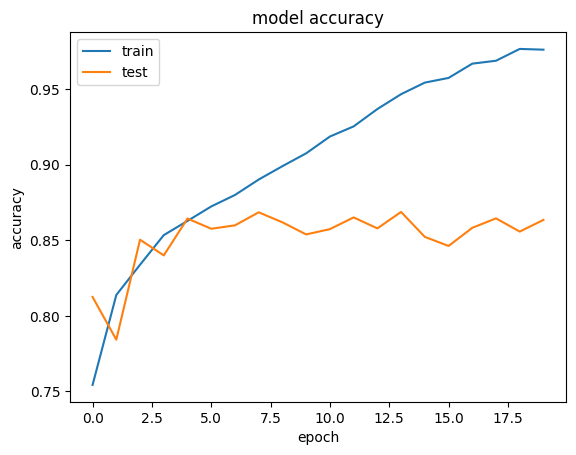

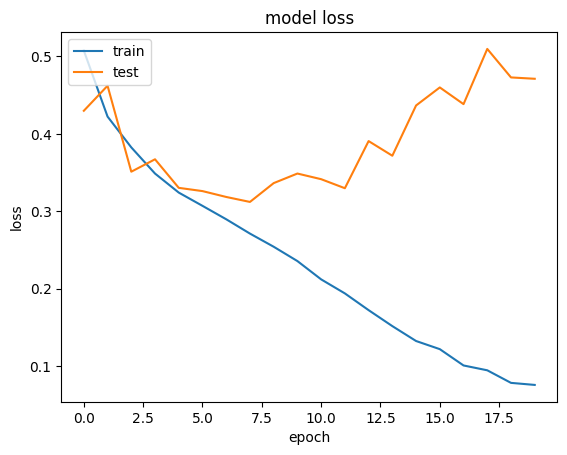

In [56]:
# Performance Visualization

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

#### Comparison

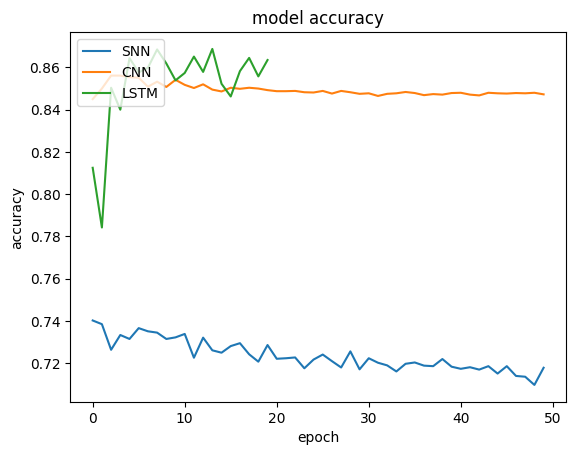

In [57]:
# comparing the performance of all the three models

plt.plot(snn_model_history.history['val_acc'])
plt.plot(cnn_model_history.history['val_acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['SNN','CNN','LSTM'], loc='upper left')
plt.show()

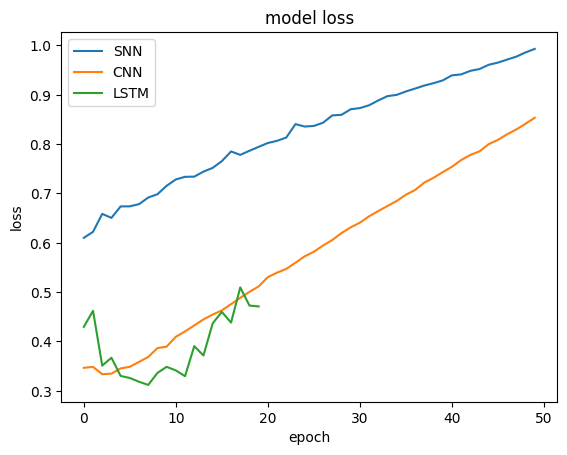

In [58]:
# comparing the performance of all the three models

plt.plot(snn_model_history.history['val_loss'])
plt.plot(cnn_model_history.history['val_loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['SNN','CNN','LSTM'], loc='upper left')
plt.show()

#### Prediction time

In [59]:
df_valid.head()

,text,label
0,years since sharon stone awarded viewers legcr...,0
1,someone needed make car payment truly awful ma...,0
2,guidelines state comment must contain minimum ...,0
3,movie muddled mishmash clichés recent cinema p...,0
4,stan laurel became smaller half alltime greate...,0


In [60]:
# Predictions on the validation set

X_valid = df_valid['text']
y_valid = df_valid['label']

X_valid = word_tokenizer.texts_to_sequences(X_valid)
X_valid = pad_sequences(X_valid, padding='post', maxlen=maxlen)

# Predictions on the validation set

y_pred_snn = snn_model.predict(X_valid)
y_pred_cnn = cnn_model.predict(X_valid)
y_pred_lstm = lstm_model.predict(X_valid)

157/157 [==============================] - 2s 15ms/step


In [61]:
# Converting the predictions into binary values
for i in range(len(y_pred_snn)):
    if y_pred_snn[i]>=0.5:
        y_pred_snn[i]=1
    else:
        y_pred_snn[i]=0

for i in range(len(y_pred_cnn)):
    if y_pred_cnn[i]>=0.5:
        y_pred_cnn[i]=1
    else:
        y_pred_cnn[i]=0

for i in range(len(y_pred_lstm)):
    if y_pred_lstm[i]>=0.5:
        y_pred_lstm[i]=1
    else:
        y_pred_lstm[i]=0

In [62]:
# Performance on the validation set
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

print("SNN Accuracy:", accuracy_score(y_valid, y_pred_snn))
print("CNN Accuracy:", accuracy_score(y_valid, y_pred_cnn))
print("LSTM Accuracy:", accuracy_score(y_valid, y_pred_lstm))

SNN Accuracy: 0.7202
CNN Accuracy: 0.8434
LSTM Accuracy: 0.8642


In [69]:
# val loss and val accuracy of all the three models

print("SNN Loss:", snn_model_history.history['val_loss'][-1])
print("CNN Loss:", cnn_model_history.history['val_loss'][-1])
print("LSTM Loss:", lstm_model_history.history['val_loss'][-1])

print("SNN Accuracy:", snn_model_history.history['val_acc'][-1])
print("CNN Accuracy:", cnn_model_history.history['val_acc'][-1])
print("LSTM Accuracy:", lstm_model_history.history['val_acc'][-1])

SNN Loss: 0.9930345416069031
CNN Loss: 0.853527843952179
LSTM Loss: 0.47111639380455017
SNN Accuracy: 0.7178750038146973
CNN Accuracy: 0.8472499847412109
LSTM Accuracy: 0.8634999990463257


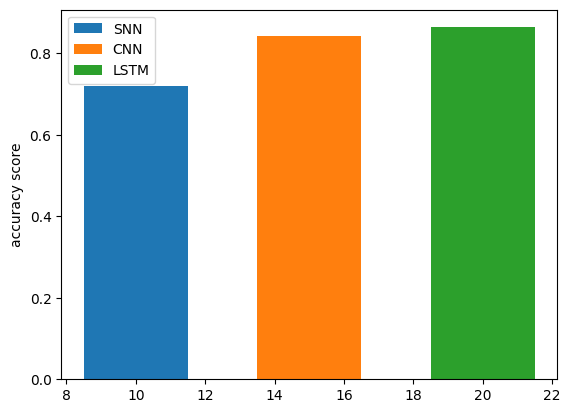

In [67]:
# plot accuracy scores of all the three models

plt.bar(10,accuracy_score(y_valid, y_pred_snn),3, label="SNN")
plt.bar(15,accuracy_score(y_valid, y_pred_cnn),3, label="CNN")
plt.bar(20,accuracy_score(y_valid, y_pred_lstm),3, label="LSTM")
plt.legend()
plt.ylabel('accuracy score')
plt.show()

In [63]:
# plot the confusion matrix
cm_snn = confusion_matrix(y_valid, y_pred_snn)
cm_cnn = confusion_matrix(y_valid, y_pred_cnn)
cm_lstm = confusion_matrix(y_valid, y_pred_lstm)

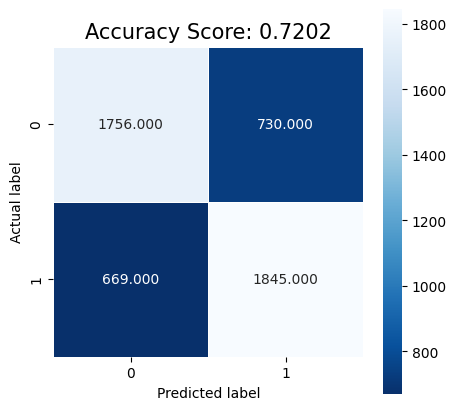

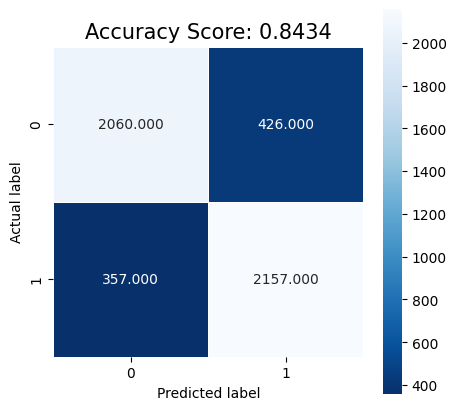

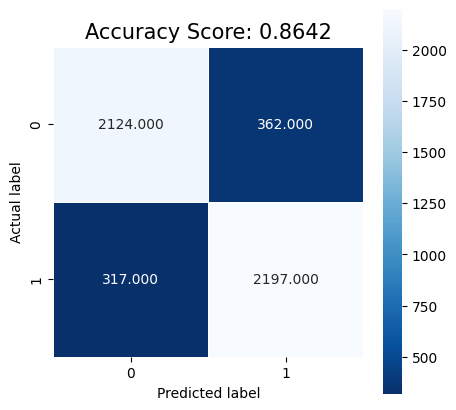

In [68]:
# plot the confusion matrix for SNN 

plt.figure(figsize=(5,5))
sns.heatmap(cm_snn, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_valid, y_pred_snn))
plt.title(all_sample_title, size = 15);

# plot the confusion matrix for CNN

plt.figure(figsize=(5,5))
sns.heatmap(cm_cnn, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_valid, y_pred_cnn))
plt.title(all_sample_title, size = 15);

# plot the confusion matrix for LSTM

plt.figure(figsize=(5,5))
sns.heatmap(cm_lstm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_valid, y_pred_lstm))
plt.title(all_sample_title, size = 15);
